In [1]:
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import mapping
import cv2
import numpy as np

import rasterio.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def normilize(x, x_min, x_max, a=0, b=255):
    x[x< x_min] = x_min
    x[x>x_max] = x_max
    x_norm = (b - a) * ((x - x_min)/(x_max - x_min)) + a
    return x_norm

In [3]:
norm_dict ={
    "B01": {'min': 1000,
          "max":1700},
    "B02": {'min': 1000,
          "max":2000},
    "B03": {'min': 1000,
      "max":2000},
    "B04": {'min': 1000,
      "max":3000},
    "B05": {'min': 1000,
      "max":3000},
    "B06": {'min': 1000,
      "max":4000},
    "B07": {'min': 2000,
      "max":4000},
    "B08": {'min': 1800,
      "max":3600},
    "B08A": {'min': 2000,
      "max":4000},
    "B09": {'min': 380,
      "max":800},
    "B10": {'min': 10,
      "max":20},
    "B11": {'min': 10,
      "max":20},
    "B11": {'min': 2000,
      "max":5000},
    "B12": {'min': 1000,
      "max":4000},
}

In [4]:
train_df = gpd.read_file("/home/user/projects/africa_starving/data/train/train/train_repr.geojson")

In [5]:
raster_path = "/home/user/projects/africa_starving/data/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_TCI.jp2"

In [6]:
save_path = "/".join(raster_path.split("/")[:7]) + 'train_only_crop'

In [7]:
save_path

'/home/user/projects/africa_starving/data/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFEtrain_only_crop'

In [8]:
src = rasterio.open(raster_path, 'r')
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        #masked_image = normalize(masked_image, x_min=norm_dict.get("B08").get('min'), x_max=norm_dict.get("B08").get('max'))
    except:
        continue
#     masked_meta = src.meta.copy()
#     masked_meta.update({"driver": "GTiff",
#                         "height": masked_image.shape[1],
#                         "width": masked_image.shape[2],
#                         "transform": out_transform})
    break

In [9]:
img_to_test = rasterio.plot.reshape_as_image(masked_image)

In [10]:
h, w, c = img_to_test.shape

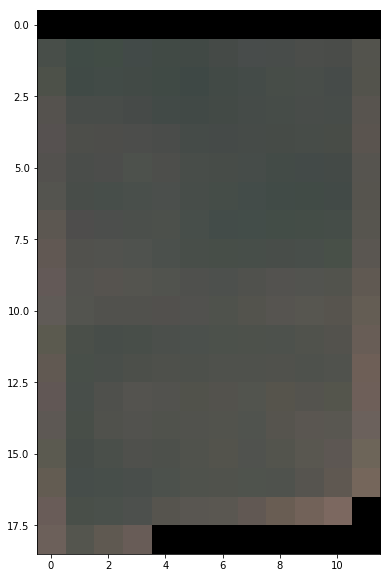

In [11]:
plt.figure(figsize=(15,10))
plt.imshow(img_to_test)

In [80]:
def pad_with_gaus(img, pad_size):
    h, w, c = img.shape
    top = (pad_size - h) // 2
    bottom = pad_size - top - h
    left = (pad_size - w) // 2
    right = pad_size - left - w
    out_img=cv2.copyMakeBorder(img, bottom, top, left, right ,cv2.BORDER_CONSTANT, 0)
    px_dict = generate_pixel_list(img)
    np.random.shuffle(px_dict)
    np.place(out_img, out_img == 0, px_dict)
    return out_img

In [103]:
def pad_with_wrap(img, pad_size):
    h, w, c = img.shape
    top = (pad_size - h) // 2
    bottom = pad_size - top - h
    left = (pad_size - w) // 2
    right = pad_size - left - w
    
    px_dict = generate_pixel_list(img)
    np.random.shuffle(px_dict)
    np.place(img, img == 0, px_dict)
    out_img=cv2.copyMakeBorder(img, bottom, top, left, right ,cv2.BORDER_WRAP)
    return out_img

In [81]:
def generate_pixel_list(inp_image):
    pixel_dict = inp_image[np.all(inp_image != 0, axis=-1)]
    return pixel_dict

In [82]:
out_img_x = pad_with_gaus(img_to_test, 64)

In [104]:
out_img_wrap = pad_with_wrap(img_to_test, 64)

In [83]:
img_to_test.shape

(19, 12, 3)

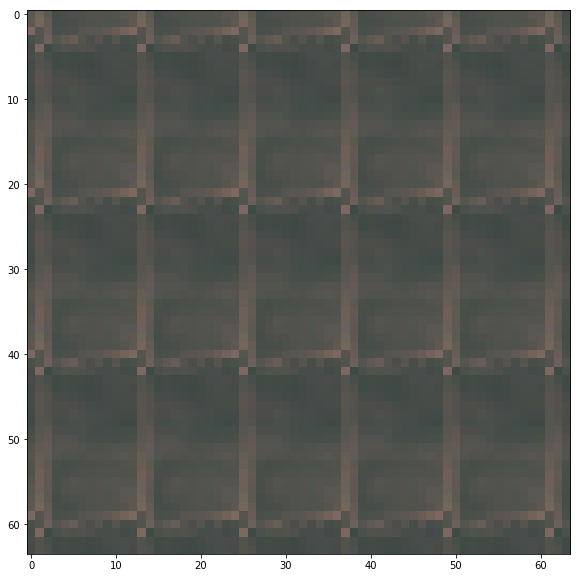

In [105]:
plt.figure(figsize=(10,10))
plt.imshow(out_img_wrap)

In [120]:
np.sum(img_to_test[:, :, 0] == 0)

21

In [132]:
np.place(img_to_test[:, :, 0], img_to_test[:, :, 0] == 0, np.ones(21, dtype=np.uint8))

In [146]:
img_to_test[10, 10]

array([87, 84, 78], dtype=uint8)

In [100]:
arr_2 = img_to_test[:, :, 0].flatten()

In [106]:
np.count_nonzero(arr_2)

207

In [108]:
np.sum(arr_2 == 0)

21

(array([26., 53., 47., 42., 14., 12.,  5.,  5.,  2.,  1.]),
 array([ 62. ,  68.2,  74.4,  80.6,  86.8,  93. ,  99.2, 105.4, 111.6,
        117.8, 124. ]),
 <a list of 10 Patch objects>)

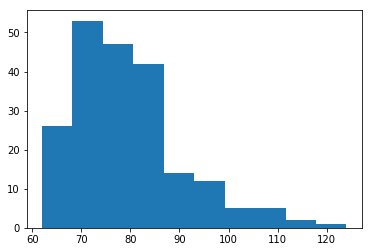

In [99]:
arr_x = img_to_test[:, :, 0].flatten()
arr_x = arr_x[arr_x != 0]
plt.hist(arr_x)

{'boxes': [<matplotlib.lines.Line2D at 0x7fc2553ad320>],
 'caps': [<matplotlib.lines.Line2D at 0x7fc2553add30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc2553b79e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fc2553b75c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fc2553ad470>,
  <matplotlib.lines.Line2D at 0x7fc2553ad908>]}

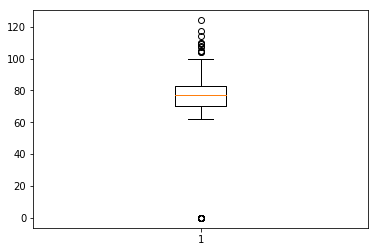

In [100]:
needed = 64
top = (needed - h) // 2
bottom = needed - top - h
left = (needed - w) // 2
right = needed - left - w
constant=cv2.copyMakeBorder(img_to_test,bottom, top, left, right ,cv2.BORDER_WRAP)

In [101]:
constant.shape

(64, 64, 3)

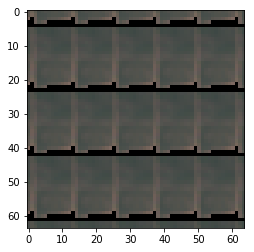

In [102]:
plt.imshow(constant)

In [41]:
x_nirm = normilize(masked_image, x_min=norm_dict.get("B08").get('min'), x_max=norm_dict.get("B08").get('max'))

In [42]:
x_nirm.max()

240.83333333333331

In [35]:
norm_dict.get("B08").get('min')

1800

In [36]:
norm_dict.get("B08").get('max')

3600

In [8]:
train_df.crs

{'init': 'epsg:32734'}

In [9]:
src.crs

CRS({'init': 'epsg:32734'})

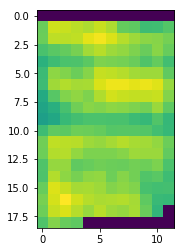

In [43]:
plt.imshow(x_nirm[0])

In [20]:
masked_image.max()

2835

In [21]:
masked_image.max()

2835